In [1]:
#Step 8 trains on the data from the hospital BIDMC and tests on the patients in MGB using random forest. 
#This data is coming from the training data only. 

In [ ]:
#Import all of the necessary modules. 
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
import pickle
import csv

In [2]:
#Load in the training data. 
X = pd.read_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/train_data_.csv')

#Load y_data_pre from CSV and select relevant columns. 
y_data = X[['BDSPPatientID', 'annot', 'hospital']]
y = y_data['annot']


#Merge X and y based on 'BDSPPatientID'. 
Xy = pd.read_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/train_data_.csv')


In [4]:
#The following code is used to train the data on BIDMC patients with their assigned features and test it on MGB. 
#This code also calculates the importances of the features. 
X = Xy.iloc[:,:-1]
y = Xy.iloc[:,-2]
X = X.loc[:, "CT":"ICD_852.2or3"]

train_hospital = 'BIDMC'
test_hospital = 'MGB'

X_train = X[Xy['hospital'] == train_hospital]
y_train = y[Xy['hospital'] == train_hospital]

X_test = X[Xy['hospital'] == test_hospital]
y_test = y[Xy['hospital'] == test_hospital]

#Filter the feature matrix to focus on features only. 
X_train = X_train.loc[:, "CT":"ICD_852.2or3"] 
X_test = X_test.loc[:, "CT":"ICD_852.2or3"]

#Initialize variables for storing results.
all_predictions = []
all_true_labels = []
all_row_numbers = []
auc_cv = []
auc_pr = []
f1_cv = []
cf_cv = []
predictions = []
roc_curves = []
pr_curves = []
feature_importances_dict = {feature: [] for feature in X.columns}
model = RandomForestClassifier(
    n_estimators=100,
    random_state=2023,
    n_jobs=-1
)
search_spaces = {
    'n_estimators': (10, 200),
    'max_depth': (2, 10),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
}
model_cv = BayesSearchCV(
    model,
    search_spaces,
    n_iter=50,
    scoring='roc_auc',
    n_jobs=47,
    cv=10,
    random_state=2023
)
model_cv.fit(X_train, y_train)
model = model_cv.best_estimator_

ytr_pred = model.predict_proba(X_train)[:, 1]
yte_pred = model.predict_proba(X_test)[:, 1]
fpr, tpr, cutoffs = roc_curve(y_train, ytr_pred)
best_cutoff = cutoffs[np.argmax(tpr - fpr)]
yte_pred_bin = (yte_pred > best_cutoff).astype(int)
auc_cv.append(roc_auc_score(y_test, yte_pred))
f1_cv.append(f1_score(y_test, yte_pred_bin))
cf_cv.append(confusion_matrix(y_test, yte_pred_bin))
predictions.append(yte_pred_bin)
model_filename = f'model_train_BIDMC_MGB_test_RF__best_model.pickle'
with open(model_filename, 'wb') as f:
    pickle.dump({'model':model, 'cutoff':best_cutoff}, f)
fpr, tpr, cutoffs = roc_curve(y_test, yte_pred)
all_predictions.extend(yte_pred_bin)
all_true_labels.extend(y_test)
all_row_numbers.extend(y_data[y_data['hospital'] == test_hospital]['BDSPPatientID'])
roc_curves.append((fpr, tpr, roc_auc_score(y_test, yte_pred)))
precision, recall, thresholds = precision_recall_curve(y_test, yte_pred)
pr_curves.append((recall, precision, auc(recall, precision)))
auc_pr_loop = auc(recall, precision)
auc_pr.append(auc_pr_loop)
feature_importances = model.feature_importances_
for feature, importance in zip(X.columns, feature_importances):
    feature_importances_dict[feature].append(importance)
print("Feature importances for this fold:")
print(pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False))
print(auc_cv)
print(auc_pr)

/home/gregory178/Desktop/NAX project/.conda/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/gregory178/Desktop/NAX project/.conda/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Feature importances for this fold:
             Feature  Importance
24           sdh_pos    0.263693
25        subdur_pos    0.085068
21  neurosurgeri_pos    0.074830
13      hematoma_pos    0.064439
68         ICD_S06.5    0.058855
..               ...         ...
43         evacu_neg    0.000000
37     burr hole_neg    0.000000
34      acut sdh_neg    0.000000
32    resolv sdh_pos    0.000000
35  brain injuri_neg    0.000000

[71 rows x 2 columns]
[0.9574391592920354]
[0.8168754153658295]


In [6]:
#Print the AUROC and AUPRC.
print(auc_cv)
print(auc_pr)

[0.9574391592920354]
[0.8168754153658295]


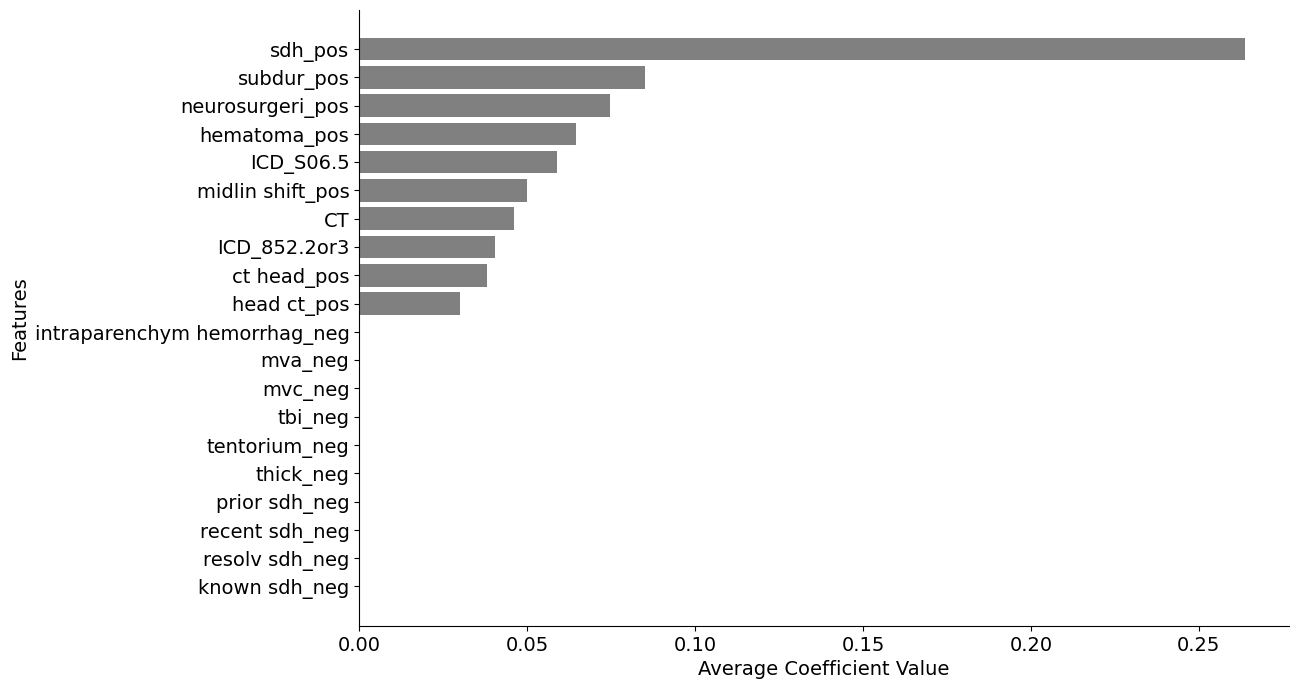

In [11]:
#Create the feature importances list. 
#Convert to a DataFrame. 
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

#Save to a CSV.
feature_importances_df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/RF_trainBIDMC_testMGB_feat_importances_.csv', index=False)

#Aggregate feature importances by averaging over folds.
avg_feature_importances = {feature: np.mean(importances) for feature, importances in feature_importances_dict.items()}
sorted_features = sorted(avg_feature_importances.items(), key=lambda item: item[1], reverse=True)
features, importances = zip(*sorted_features)

#Select the top 10 and bottom 10 features. 
top_features = features[:10]
top_importances = importances[:10]
bottom_features = features[-10:]
bottom_importances = importances[-10:]

#Combine the top and bottom features for plotting. 
plot_features = top_features + bottom_features
plot_importances = top_importances + bottom_importances

#Plot feature importances. 
plt.figure(figsize=(12, 8))
plt.barh(plot_features, plot_importances, color='grey')  
plt.xlabel('Average Coefficient Value', fontsize=14)
plt.ylabel('Features', fontsize=14)  
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()  
plt.savefig('/home/gregory178/Desktop/NAX project/NAX_SDH/RF_trainBIDMC_testMGB_feat_importances_.png')  
plt.show()

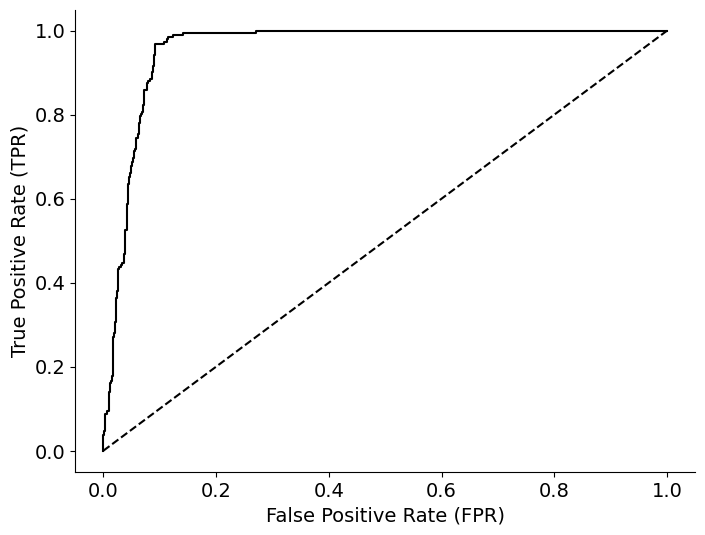

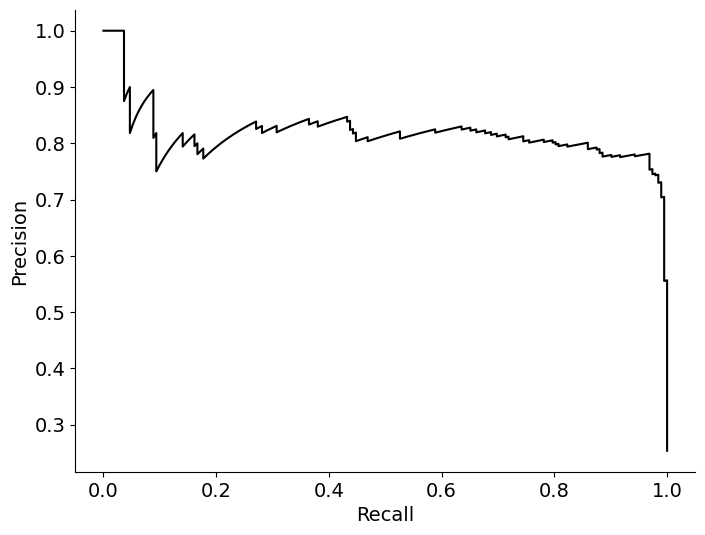

0.9574391592920354
[0.8168754153658295]
0.7492957746478873


In [12]:
#Make the AUROC and AUPRC curves. 

#Plot all ROC curves overlaid on a single graph.
plt.figure(figsize=(8, 6))

for fpr, tpr, auc_score in roc_curves:
    plt.plot(fpr, tpr, color='black')  

plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)

#Set font size for ticks to 14. 
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

#Remove the top and right spines.
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#Removed plt.title() and plt.legend(). 
plt.savefig('/home/gregory178/Desktop/NAX project/NAX_SDH/RF_AUC_iter_MGB_.png')
plt.show()

#Plot all the PR curves overlaid on a single graph.
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='black')  
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

#Remove the top and right spines.
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


#Removed plt.title() and plt.legend().
plt.savefig('/home/gregory178/Desktop/NAX project/NAX_SDH/RF_PR_iter_MGB_.png')
plt.show()

#Create a DataFrame to hold the results. 
results_df = pd.DataFrame({'Unnamed: 0': all_row_numbers, 'annot': all_true_labels, 'prediction': all_predictions})

#Save the DataFrame to a CSV file.
results_df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/RF_LR_iter_pred_MGB_.csv', index=False)

#Calculate the final AUROC and F1 Score.
auc_final = np.mean(auc_cv)
f1_final = np.mean(f1_cv)

# Save all the data
df = pd.DataFrame()
df['auc'] = auc_cv
df['f1s'] = f1_cv
df['auc_pr'] = auc_pr
df_pred = pd.DataFrame()
df1 = pd.DataFrame(predictions[0])
df_pred = pd.concat([df1]).reset_index()
df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/RF_LR_iter_MGB_.csv')

# Print the final Data.
print(auc_final)
print(auc_pr)
print(f1_final)